In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import glob
from tqdm import tqdm
import sys
import os

import barbershop
from inv_bol import Astero_Clump

from scipy import integrate
from pystellibs import Kurucz
from synphot import SpectralElement

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
#Define solar parameters
Rsol = 695700e3 #meters
Tsol = 5778 #K
Msol = 1.989e30 #Kg
Numaxsol = 3090 #Huber et al 2011ish
Dnusol = 135.1
stefboltz = 5.670367e-8 #Wm-2K-4
Lsol = 4 * np.pi * stefboltz * Rsol**2 * Tsol**4
gsol = 27400. #cms^2
Zsol = 0.01756
Asol = 4 * np.pi * (Rsol*100)**2

Mbolsol = 4.74  #Torres 2010?
Mksol = 3.28 #Bohlin & Gilliland 2004
Mabssol_err = 0.09
Mjsol = 3.64
Mhsol = 3.32

In [6]:
def get_yu():
    #Read in Jie Yu
    print('Reading in Yu+2018')
    sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table1.txt'
    yu18_1 = pd.read_csv(sfile, sep='|')
    sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table2.txt'
    yu18_2 = pd.read_csv(sfile, sep='|')
    yu18 = pd.merge(yu18_1, yu18_2, on='KICID',how='outer')
    yu18.rename(columns={'KICID':'KIC','EvoPhase':'stage'},inplace=True) #For consistency
    yu18.stage[yu18.stage == 0] = 'U'
    yu18.stage[yu18.stage == 1] = 'RGB'
    yu18.stage[yu18.stage == 2] = 'HeB'

    #Lets build our new dataframe!
    df = pd.DataFrame()
    HeB = yu18.stage == 'HeB'
    df['KIC'] = yu18.KIC[HeB]
    df['numax'] = yu18.numax[HeB]
    df['numax_err'] = yu18['err_x'][HeB]
    df['dnu'] = yu18.dnu
    df['dnu_err'] = yu18['err.1_x'][HeB]
    df['Teff'] = yu18.Teff[HeB]
    df['Teff_err'] = yu18['err_y'][HeB]
    df['[Fe/H]'] = yu18['Fe/H'][HeB]
    df['[Fe/H]_err'] = yu18['err.2_y'][HeB]
    df['logg'] = yu18['logg'][HeB]
    df['logg_err'] = yu18['err.1_y'][HeB]
    df['M'] = yu18['M_noCorrection'][HeB]
    df['M_err'] = yu18['err.3_y'][HeB]
    df['R'] = yu18['R_noCorrection'][HeB]
    df['R_err'] = yu18['err.4_y'][HeB]
    df['Z'] = Zsol * 10**df['[Fe/H]']
    return df

df = get_yu()

Reading in Yu+2018


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
'''Lets build up the catalogue to Mbol for these stars
The asteroseismic values are already computed in Yu+18'''
AC = Astero_Clump(df, df.numax, df.dnu, df.Teff,\
                 _numax_err = df.numax_err, _dnu_err = df.dnu_err, _Teff_err = df.Teff_err)
df['L'] = AC.get_luminosity()/Lsol
df['L_err'] = AC.get_luminosity_err()/Lsol
df['Mbol'] = AC.get_bolmag()
df['Mbol_err'] = AC.get_bolmag_err()

In [8]:
'''Now lets make a simple call for the spectrum on one of these'''
spect = Kurucz() #Call in the spectrum
tracks = 'Kurucz'

'''[logT, logg, logL, Z]'''
ap = (np.log10(Tsol), np.log10(gsol), np.log10(Lsol), Zsol) 
print(ap)
sb = spect.generate_stellar_spectrum(*ap)

(3.7617775375081783, 4.437750562820388, 26.584775189172156, 0.01756)


In [9]:
'''We want Bessel K'''
J = SpectralElement.from_filter('bessel_j')
H = SpectralElement.from_filter('bessel_h')
K = SpectralElement.from_filter('bessel_k')


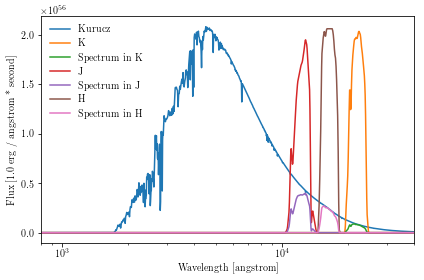

In [10]:
plt.figure()
plt.semilogx(spect._wavelength, sb, label=tracks)
plt.semilogx(spect._wavelength, K(spect._wavelength)*sb.max(), label='K')
plt.semilogx(spect._wavelength, sb*K(spect._wavelength), label='Spectrum in K')
plt.semilogx(spect._wavelength, J(spect._wavelength)*sb.max(), label='J')
plt.semilogx(spect._wavelength, sb*J(spect._wavelength), label='Spectrum in J')
plt.semilogx(spect._wavelength, H(spect._wavelength)*sb.max(), label='H')
plt.semilogx(spect._wavelength, sb*H(spect._wavelength), label='Spectrum in H')
plt.legend(frameon=False, loc='upper left')
plt.xlabel('Wavelength [{0}]'.format(spect.wavelength_unit))
plt.xlim(800, 4e4)
plt.ylabel('Flux [{0}]'.format(spect.flux_units))
plt.tight_layout()
plt.show()

In [24]:
'''Now lets do the integration'''
fl = integrate.simps(sb, x=spect._wavelength)
Kslfl = integrate.simps(sb * K(spect._wavelength), x=spect._wavelength)
Jslfl = integrate.simps(sb * J(spect._wavelength), x=spect._wavelength)
Hslfl = integrate.simps(sb * H(spect._wavelength), x=spect._wavelength)
print(fl)
print(Kslfl/fl)
print(Jslfl/fl)
print(Hslfl/fl)

1.4768221182950963e+60
0.020805246488579635
0.06029499808453857
0.04553389216411663


In [25]:
'''Now lets follow the Torres+10 calculation'''
Ck = Mbolsol - Mksol - 2.5*np.log10(Kslfl/fl)
Cj = Mbolsol - Mjsol - 2.5*np.log10(Jslfl/fl)
Ch = Mbolsol - Mhsol - 2.5*np.log10(Hslfl/fl)
print(Ck)
print(Cj)
print(Ch)

5.664567836424057
4.149296785751847
4.774163063272329
